In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft
import os

In [3]:
def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames

def save_frames(frames, folder_path):
    for i, frame in enumerate(frames):
        cv2.imwrite(os.path.join(folder_path, f'frame_{i}.png'), frame)


In [4]:
#
# zoom on the steem 

def crop_video(input_video_path, output_video_path, top_percentage, right_percentage):
    cap = cv2.VideoCapture(input_video_path)

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (int(width * right_percentage), int(height * top_percentage)))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Crop the frame
        cropped_frame = frame[:int(height * top_percentage), :int(width * right_percentage)]

        # Write the cropped frame
        out.write(cropped_frame)

    # Release everything if the job is finished
    cap.release()
    out.release()

## Binarize frames 

In [5]:
def rgb_to_hsv(frame):
    return cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

def remove_noise(frame, kernel_size=3):
    return cv2.medianBlur(frame, kernel_size)

def fuse_regions(frame, kernel_size=5):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated = cv2.dilate(frame, kernel, iterations=1)
    result = cv2.erode(dilated, kernel, iterations=1)
    return result


In [6]:
#find red marker on binarize frames 
def detect_red_marker(frame, h_range=[5, 165], s_range=[60, 120], v_range=[150, 255]):
    img_hsv = rgb_to_hsv(frame)
    blur = remove_noise(img_hsv)
    h_in_range = (blur[:,:,0] >= h_range[0]) & (blur[:,:,0] <= h_range[1])
    s_in_range = (blur[:,:,1] >= s_range[0]) & (blur[:,:,1] <= s_range[1])
    v_in_range = (blur[:,:,2] >= v_range[0]) & (blur[:,:,2] <= v_range[1])
    mask = np.uint8(h_in_range & s_in_range & v_in_range) * 255
    return fuse_regions(mask)



In [7]:
#from https://github.com/MTNakata/AraVib/blob/master/AraVib_modules/AraVib_img_to_vibwave.py#L4
def red_trace_generate(frame, h, s, v):
    img_hsv = cv2.cvtColor(frame[0:600,:,:], cv2.COLOR_BGR2HSV)
    blur = cv2.blur(img_hsv,(3,3))
    h_165 = blur[:,:,0]> h[1]
    h_5 = blur[:,:,0]< h[0]
    h_5_165 = h_5|h_165
    s_100 = blur[:,:,1]>s
    v_90 = blur[:,:,2]>v
    return np.uint8(h_5_165&s_100&v_90) * 255

def red_trace(frames, h=[5, 165], s=[60, 75], v=[160, 185]):
    red_trace_frames = []
    kernel1 = np.ones((2,2),np.uint8)
    kernel2 = np.ones((15,15),np.uint8)
    for frame in frames:
        binary_img = next(red_trace_generate([frame], h, s, v))
        binary_img = binary_img.astype(np.uint8) * 255  # Convert boolean mask to uint8
        erosion = cv2.erode(binary_img, kernel1, iterations = 1)
        dilated = cv2.dilate(erosion, kernel2, iterations = 1)
        red_trace_frames.append(dilated)
    return red_trace_frames



### add image pre processing technique to `red_trace_generate` function

In [8]:
def red_trace_generate(img_files, h_range, s_range, v_range):
    for i in img_files:
        # Convert to HSV
        img_hsv = cv2.cvtColor(i[0:600,:,:], cv2.COLOR_BGR2HSV)
        
        # Apply Gaussian blur
        blur = cv2.GaussianBlur(img_hsv, (3, 3), 0)
        
        # Equalize histograms (for each channel separately)
        blur[:,:,0] = cv2.equalizeHist(blur[:,:,0])
        blur[:,:,1] = cv2.equalizeHist(blur[:,:,1])
        blur[:,:,2] = cv2.equalizeHist(blur[:,:,2])
        
        # Apply color detection
        h_in_range = (blur[:,:,0] >= h_range[0]) & (blur[:,:,0] <= h_range[1])
        s_in_range = (blur[:,:,1] >= s_range[0]) & (blur[:,:,1] <= s_range[1])
        v_in_range = (blur[:,:,2] >= v_range[0]) & (blur[:,:,2] <= v_range[1])
        
        yield h_in_range & s_in_range & v_in_range


In [9]:
def mark_centroids(frames):
    marked_frames = []
    red_centroids = []
    for frame in frames:
        # Find contours
        contours, _ = cv2.findContours(frame, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        if contours:  # If any contours are found
            # Find the largest contour based on area
            largest_contour = max(contours, key=cv2.contourArea)
            
            # Get the moments of the largest contour
            M = cv2.moments(largest_contour)

            if M["m00"] != 0:
                # Calculate centroid
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                red_centroids.append((cX, cY))
                # Mark the centroid on the frame
                marked_frame = cv2.circle(frame.copy(), (cX, cY), 10, (0, 255, 0), 3)
                marked_frames.append(marked_frame)
    return red_centroids, marked_frames


In [10]:
def process_and_save(video_path):
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    print(f"\n ... Processing video : {video_path}...")

    # Extract frames
    frames = extract_frames(video_path)
    os.makedirs(f'{video_name}/frames', exist_ok=True)
    save_frames(frames, f'{video_name}/frames')
    print("\n ... Frame extracrtion OK ...\n")
    
    print("Detecting red marker...")
    # Detect red marker
    red_marker_frames = [detect_red_marker(frame) for frame in frames]
    os.makedirs(f'{video_name}/red_marker', exist_ok=True)
    save_frames(red_marker_frames, f'{video_name}/red_marker')
    
    # Mark centroids
    red_centroids, centroid_frames = mark_centroids(red_marker_frames)
    os.makedirs(f'{video_name}/centroids', exist_ok=True)
    save_frames(centroid_frames, f'{video_name}/centroids')
    print(f"\n ... Computing centroids of len {len(red_centroids)} ...\n")
    return red_centroids

In [11]:
input_video_path = '../input_vids/Col0_5c_trim.mp4'#'../input_vids/Col0 8a.mp4' #'../input_vids/test/Video_5.MP4'  #'../input_vids/Col0_3a_trim.mp4'   #  
#test_001.mov
output_video_path = '../output_frames/trim_Col0_5c.avi'
top_percentage = 0.6
right_percentage = 0.99



In [12]:
#crop video 
crop_video(input_video_path, output_video_path, top_percentage, right_percentage)

In [13]:
centroids = process_and_save(output_video_path)


 ... Processing video : ../output_frames/trim_Col0_5c.avi...

 ... Frame extracrtion OK ...

Detecting red marker...

 ... Computing centroids of len 423 ...



In [14]:
len(centroids)

423

In [15]:
centroids_test = process_and_save('../input_vids/test/Video_1.MP4')


 ... Processing video : ../input_vids/test/Video_1.MP4...

 ... Frame extracrtion OK ...

Detecting red marker...

 ... Computing centroids of len 717 ...



In [16]:
centroids_test

[(533, 353),
 (534, 352),
 (534, 351),
 (534, 352),
 (534, 351),
 (534, 351),
 (534, 352),
 (534, 352),
 (534, 351),
 (534, 352),
 (533, 352),
 (533, 353),
 (533, 353),
 (533, 353),
 (533, 352),
 (533, 352),
 (533, 352),
 (533, 352),
 (533, 352),
 (533, 352),
 (533, 353),
 (533, 352),
 (533, 353),
 (533, 353),
 (533, 354),
 (533, 353),
 (533, 354),
 (534, 353),
 (533, 355),
 (533, 355),
 (534, 353),
 (535, 353),
 (533, 356),
 (534, 355),
 (534, 355),
 (534, 356),
 (535, 356),
 (535, 357),
 (535, 357),
 (535, 358),
 (536, 357),
 (537, 356),
 (536, 359),
 (536, 359),
 (535, 361),
 (536, 361),
 (536, 361),
 (535, 362),
 (536, 362),
 (535, 362),
 (536, 362),
 (536, 361),
 (536, 362),
 (536, 363),
 (535, 364),
 (538, 359),
 (538, 358),
 (538, 358),
 (539, 357),
 (539, 358),
 (540, 357),
 (538, 360),
 (540, 356),
 (540, 357),
 (540, 357),
 (540, 357),
 (539, 358),
 (539, 358),
 (539, 358),
 (539, 361),
 (539, 359),
 (539, 360),
 (540, 359),
 (540, 358),
 (539, 360),
 (540, 359),
 (540, 359),

# try other pre-processing methods 


In [17]:
def process_and_mark(video_path):
    # Extract frames
    print("Extracting frames...")
    frames = extract_frames(video_path)
    
    # Apply red_trace
    print("Applying red trace...")
    red_trace_frames = red_trace(frames)
    
    # Save frames
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    os.makedirs(f'{video_name}/red_trace', exist_ok=True)
    print(f"Saving frames to {video_name}/red_trace folder...")
    save_frames(red_trace_frames, f'{video_name}/red_trace')


In [18]:
centroid_m = process_and_mark('../input_vids/test/Video_1.MP4')

Extracting frames...
Applying red trace...
Saving frames to Video_1/red_trace folder...


### view HSV impact

In [47]:
def get_red_centroid(frame):
    # Convert the frame to HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define range for red color in HSV
    lower_red = np.array([0, 120, 70])
    upper_red = np.array([10, 255, 255])

    # Threshold the HSV image to get only red colors
    mask1 = cv2.inRange(hsv, lower_red, upper_red)

    lower_red = np.array([170, 120, 70])
    upper_red = np.array([180, 255, 255])
    mask2 = cv2.inRange(hsv, lower_red, upper_red)

    # Bitwise-OR mask1 and mask2
    mask = mask1 | mask2

    # Perform morphological operations to get rid of noise
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0:
        # Find the largest contour
        c = max(contours, key=cv2.contourArea)

        # Find the centroid of the largest contour
        M = cv2.moments(c)
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])

        # Draw a circle on the frame at the centroid
        marked_frame = cv2.circle(frame.copy(), (cx, cy), 10, (0, 255, 0), 3)
        return marked_frame

    return frame  # Return original frame if no red found


In [20]:
def get_red_centroid_from_frame(hsv_filtered_frame, erode_iter=2, dilate_iter=2):
    # Convert the HSV image to binary
    _, binary_img = cv2.threshold(hsv_filtered_frame, 0, 255, cv2.THRESH_BINARY)

    # Perform morphological operations to get rid of noise
    kernel = np.ones((5,5),np.uint8)
    mask = cv2.erode(binary_img, kernel, iterations=erode_iter)
    mask = cv2.dilate(mask, kernel, iterations=dilate_iter)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0:
        # Find the largest contour
        c = max(contours, key=cv2.contourArea)

        # Find the centroid of the largest contour
        M = cv2.moments(c)
        if M["m00"] != 0:  # check for division by zero
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])

            # Draw a circle on the mask at the centroid
            marked_frame = cv2.circle(mask.copy(), (cx, cy), 10, (255, 255, 255), 3)
            return marked_frame

    return mask  # Return original mask if no red found


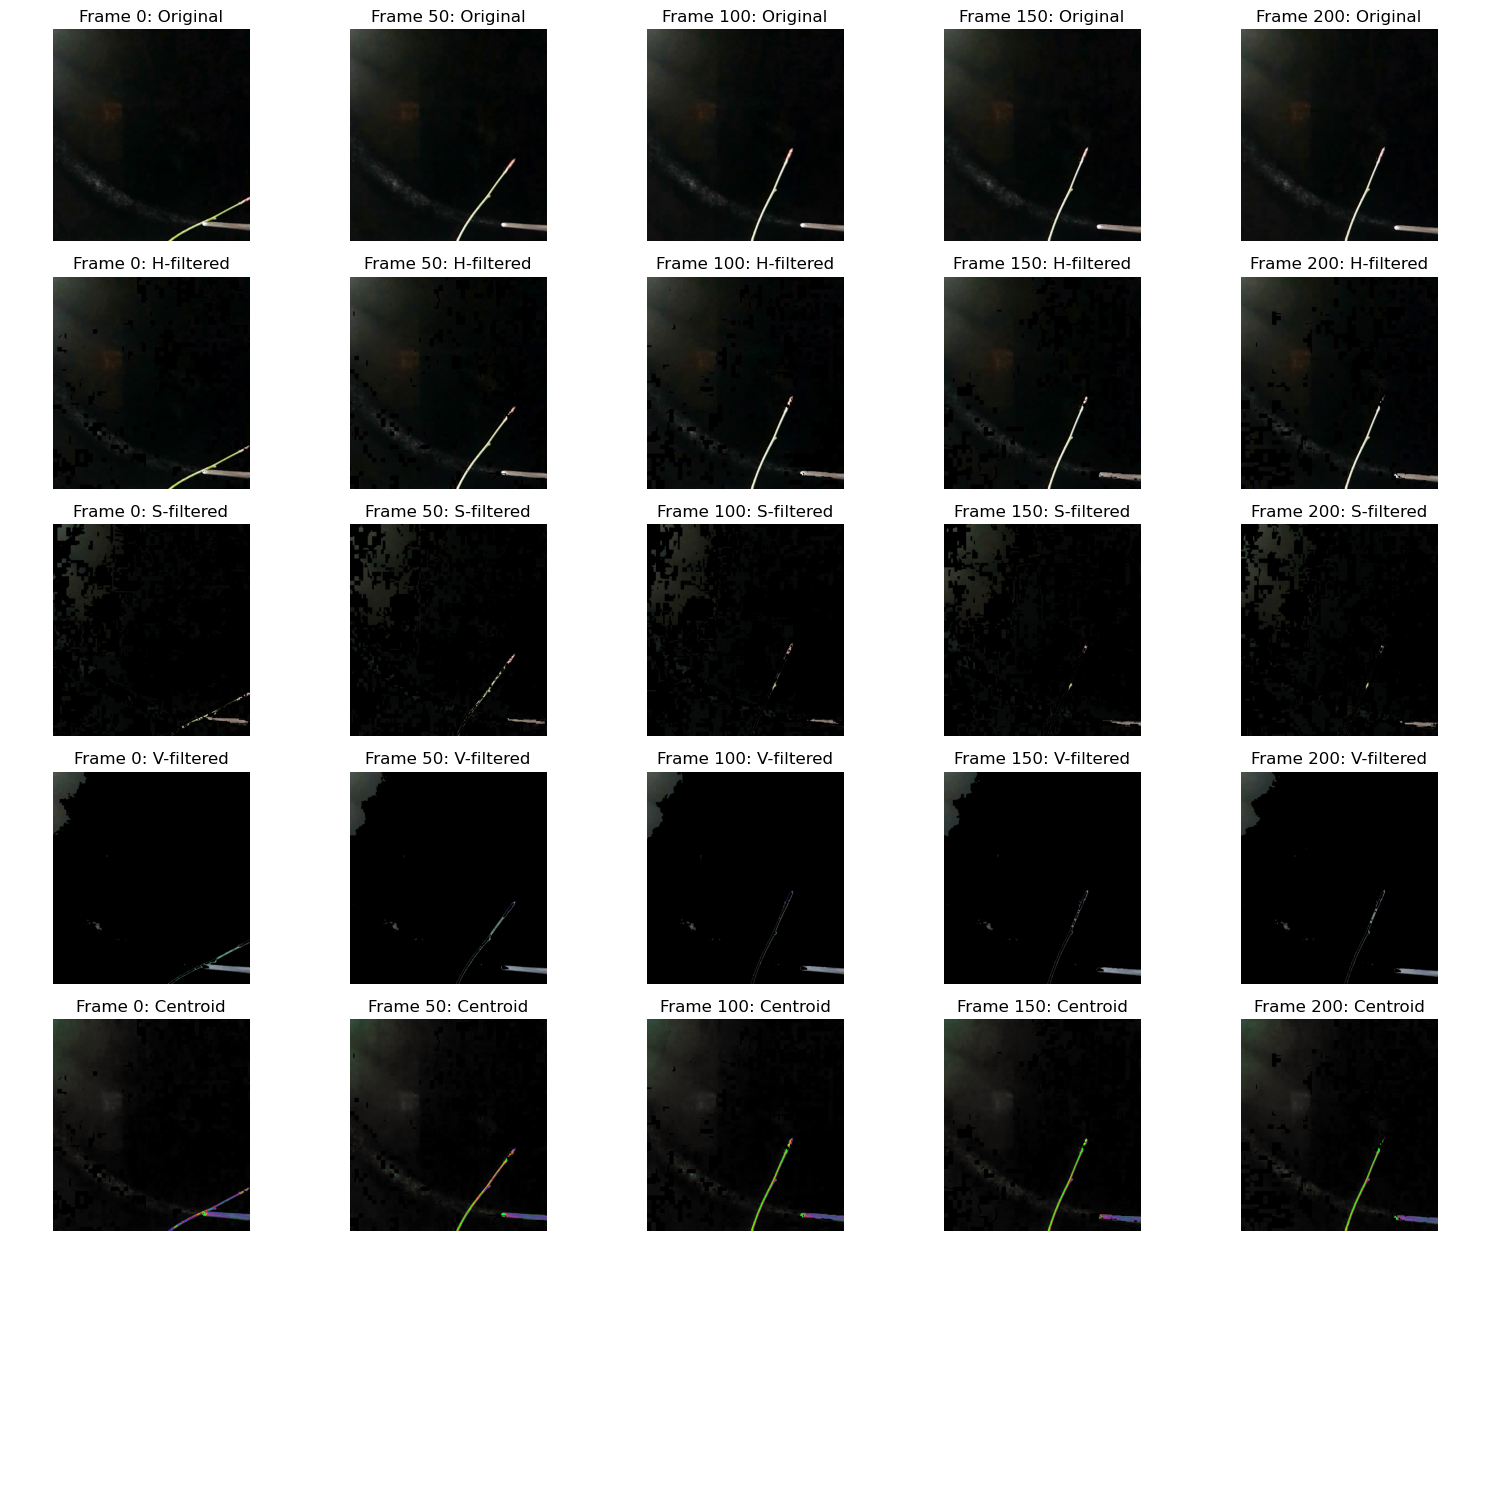

In [21]:
import matplotlib.pyplot as plt

def plot_hsv_impact(frames, frame_ids=[0, 50, 100, 150, 200], h=[5, 165], s=[40, 80], v=[50, 170]):
    fig, axs = plt.subplots(6, len(frame_ids), figsize=(15, 15))
    kernel = np.ones((5,5),np.uint8)
    
    for i, frame_id in enumerate(frame_ids):
        frame = frames[frame_id]
        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        axs[0, i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        axs[0, i].set_title(f'Frame {frame_id}: Original')

        h_mask = cv2.inRange(hsv_frame, np.array([h[0], 0, 0]), np.array([h[1], 255, 255]))
        h_frame = cv2.bitwise_and(frame, frame, mask=h_mask)
        axs[1, i].imshow(cv2.cvtColor(h_frame, cv2.COLOR_BGR2RGB))
        axs[1, i].set_title(f'Frame {frame_id}: H-filtered')

        s_mask = cv2.inRange(hsv_frame, np.array([0, s[0], 0]), np.array([180, s[1], 255]))
        s_frame = cv2.bitwise_and(frame, frame, mask=s_mask)
        axs[2, i].imshow(cv2.cvtColor(s_frame, cv2.COLOR_BGR2RGB))
        axs[2, i].set_title(f'Frame {frame_id}: S-filtered')

        v_mask = cv2.inRange(hsv_frame, np.array([0, 0, v[0]]), np.array([180, 255, v[1]]))
        v_frame = cv2.bitwise_and(frame, frame, mask=v_mask)
        #axs[3, i].imshow(cv2.cvtColor(v_frame, cv2.COLOR_BGR2RGB))
        #axs[3, i].set_title(f'Frame {frame_id}: V-filtered')
        
        v_frame = cv2.dilate(v_frame, kernel, iterations = 1)
        v_frame = cv2.erode(v_frame, kernel, iterations = 1)
        axs[3, i].imshow(v_frame)
        axs[3, i].set_title(f'Frame {frame_id}: V-filtered')

        centroid_frame = get_red_centroid(cv2.cvtColor(h_frame, cv2.COLOR_HSV2BGR))
        axs[4, i].imshow(cv2.cvtColor(centroid_frame, cv2.COLOR_BGR2RGB))
        axs[4, i].set_title(f'Frame {frame_id}: Centroid')

    for ax in axs.ravel():
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Use it as follows
video_path = '../input_vids/Col0_5c_trim.mp4'
test_video = '../input_vids/test/Video_1.MP4'
frames = extract_frames(output_video_path)
plot_hsv_impact(frames)


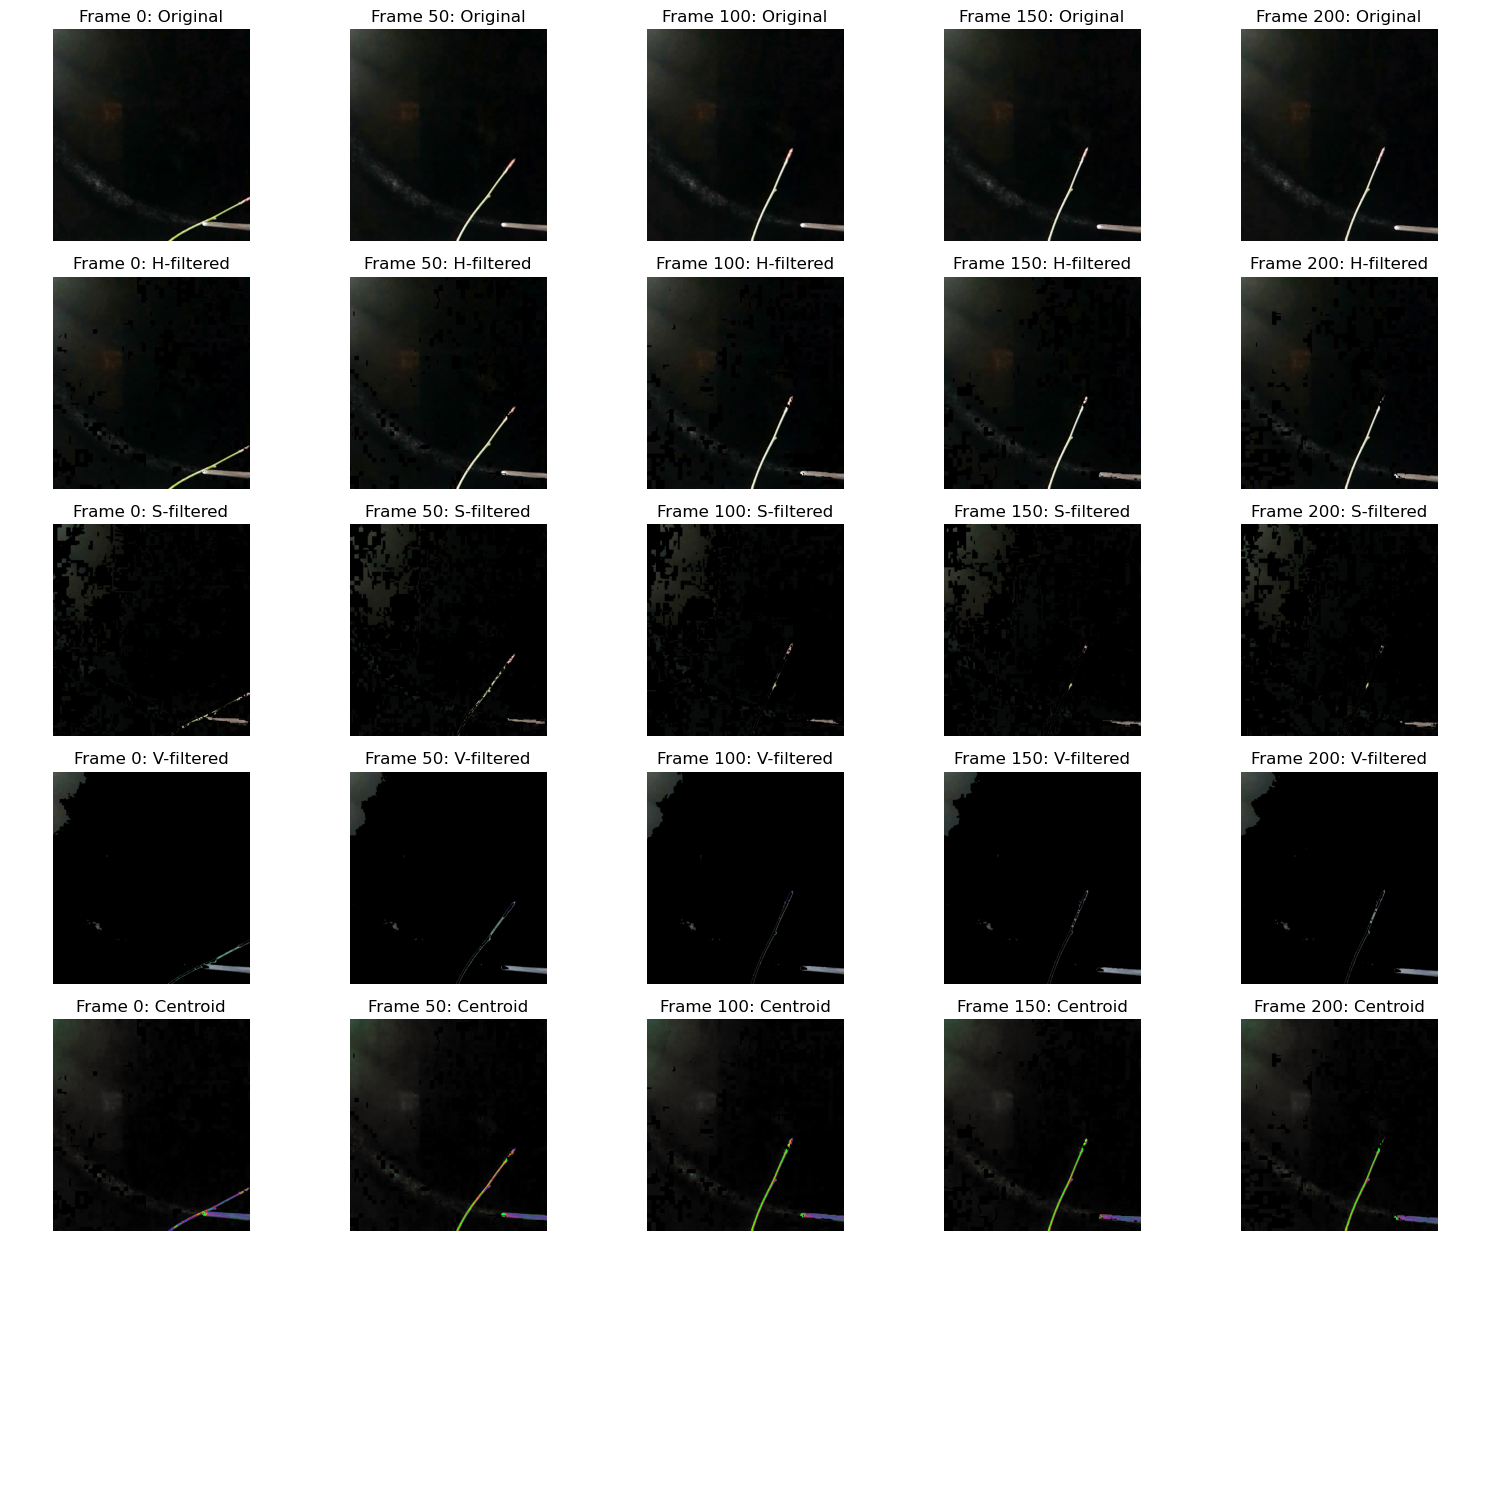

In [50]:
frames = extract_frames(output_video_path)
plot_hsv_impact(frames)

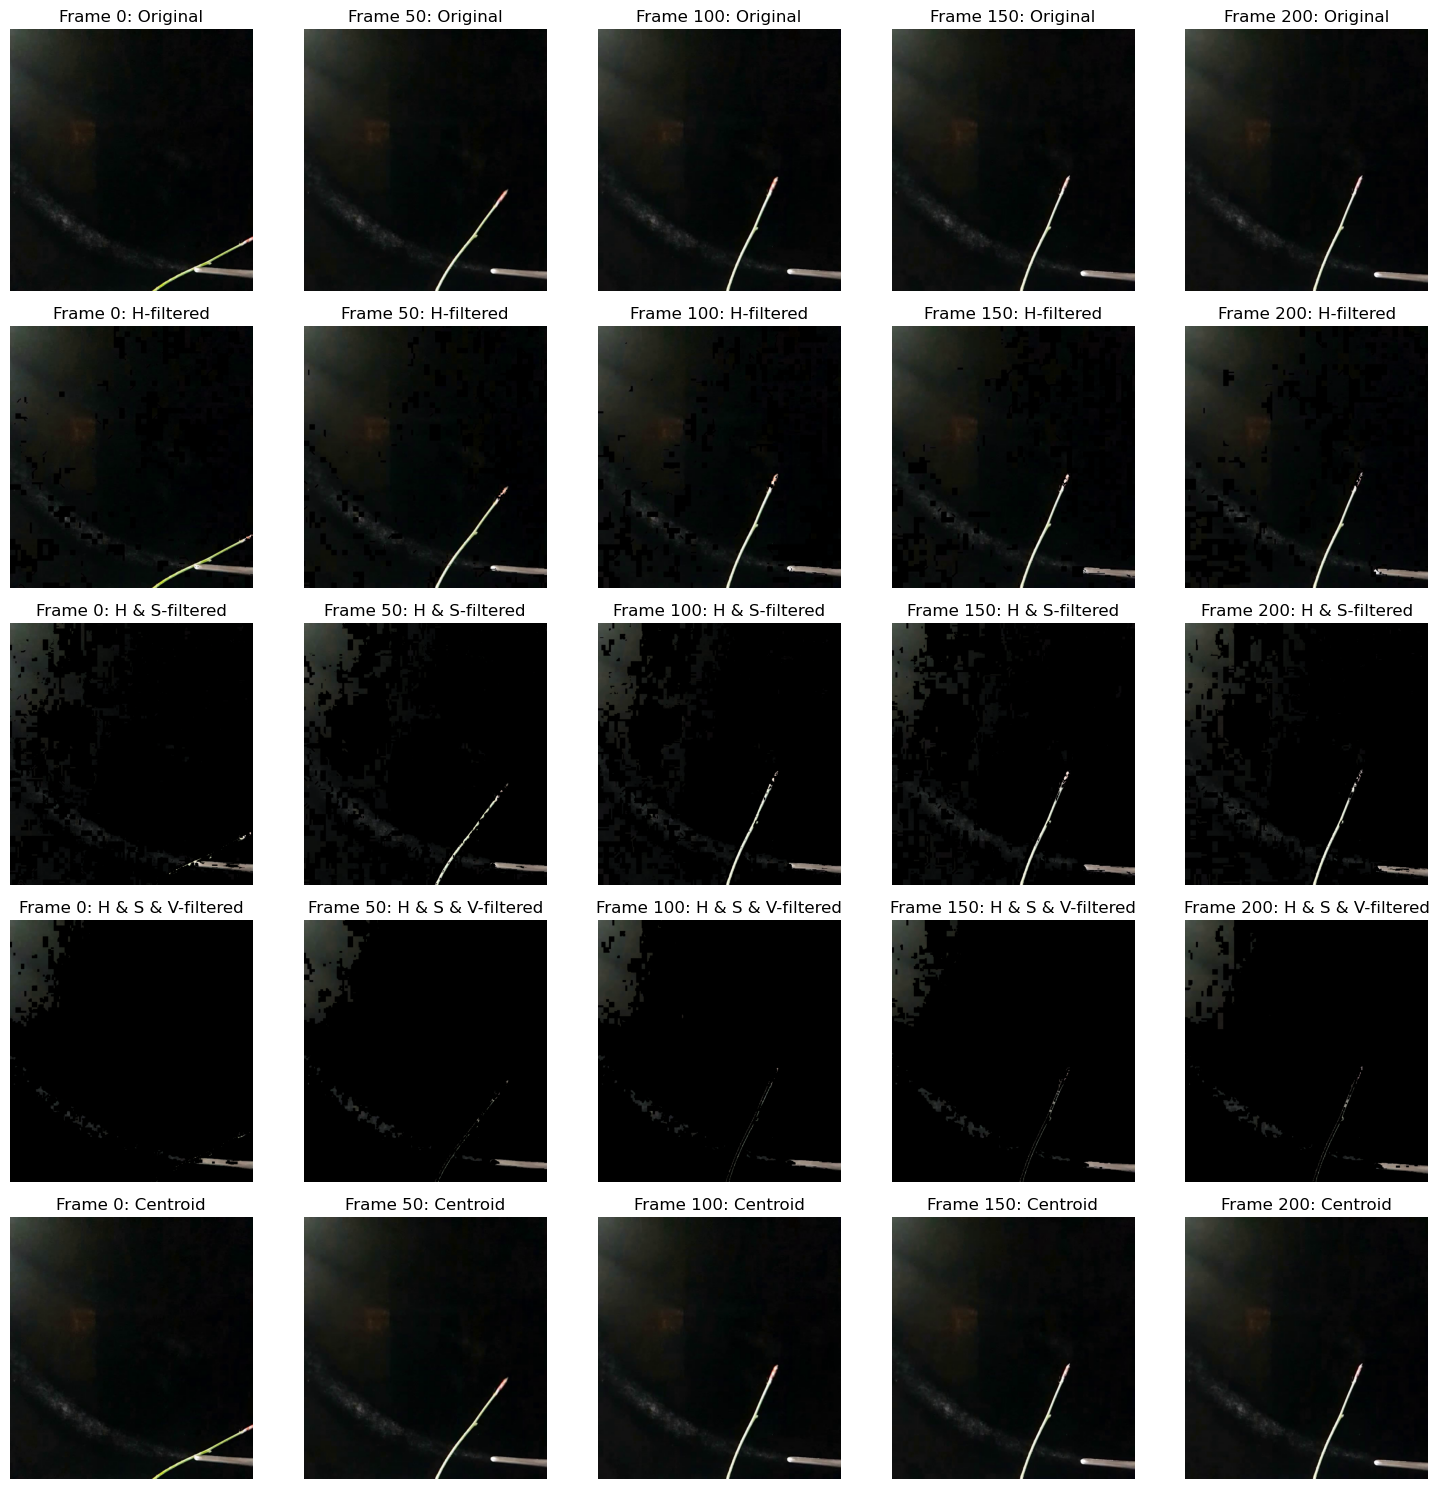

In [52]:
def plot_hsv_impact_detailed(frames, frame_ids=[0, 50, 100, 150, 200], h=[5, 175], s=[10, 50], v=[30, 170]):
    fig, axs = plt.subplots(5, len(frame_ids), figsize=(15, 15))
    kernel = np.ones((5,5),np.uint8)

    for i, frame_id in enumerate(frame_ids):
        frame = frames[frame_id]
        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        axs[0, i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        axs[0, i].set_title(f'Frame {frame_id}: Original')

        # Apply H-filter
        h_mask = cv2.inRange(hsv_frame, np.array([h[0], 0, 0]), np.array([h[1], 255, 255]))
        h_frame = cv2.bitwise_and(hsv_frame, hsv_frame, mask=h_mask)
        axs[1, i].imshow(cv2.cvtColor(cv2.cvtColor(h_frame, cv2.COLOR_HSV2BGR), cv2.COLOR_BGR2RGB))
        axs[1, i].set_title(f'Frame {frame_id}: H-filtered')

        # Apply S-filter on H-filtered image
        s_mask = cv2.inRange(h_frame, np.array([0, s[0], 0]), np.array([180, s[1], 255]))
        hs_frame = cv2.bitwise_and(h_frame, h_frame, mask=s_mask)
        axs[2, i].imshow(cv2.cvtColor(cv2.cvtColor(hs_frame, cv2.COLOR_HSV2BGR), cv2.COLOR_BGR2RGB))
        axs[2, i].set_title(f'Frame {frame_id}: H & S-filtered')

        # Apply V-filter on H & S-filtered image
        v_mask = cv2.inRange(hs_frame, np.array([0, 0, v[0]]), np.array([180, 255, v[1]]))
        hsv_frame = cv2.bitwise_and(hs_frame, hs_frame, mask=v_mask)
        hsv_frame = cv2.dilate(hsv_frame, kernel, iterations = 1)
        hsv_frame = cv2.erode(hsv_frame, kernel, iterations = 1)
        axs[3, i].imshow(cv2.cvtColor(cv2.cvtColor(hsv_frame, cv2.COLOR_HSV2BGR), cv2.COLOR_BGR2RGB))
        axs[3, i].set_title(f'Frame {frame_id}: H & S & V-filtered')

        # Apply centroid detection on H & S-filtered image
        centroid_frame = get_red_centroid(frame)
        axs[4, i].imshow(cv2.cvtColor(centroid_frame, cv2.COLOR_BGR2RGB))
        axs[4, i].set_title(f'Frame {frame_id}: Centroid')

    for ax in axs.ravel():
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    
    
# Use it as follows
video_path = '../input_vids/Col0_5c_trim.mp4'
test_video = '../input_vids/test/Video_1.MP4'
frames = extract_frames(output_video_path)
plot_hsv_impact_detailed(frames)



# Displacements data 

In [24]:
def nan_processing(array):
    array_copy = array.copy()
    for i,j in [(1,1),(1,2),(2,1),(1,3),(2,2),(3,1),
              (1,4),(4,1),(3,2),(2,3),(1,5),(5,1),(2,4),(4,2),(3,3)]:
        if np.isnan(array_copy).all():
            break
        else:
            array_right = np.roll(array_copy, i, axis=0)
            array_left = np.roll(array_copy, -j, axis=0)
            array_mean = (array_right*j + array_left*i)/(i+j)
            nan_position = np.where(np.isnan(array_copy))
            array_copy[nan_position] = array_mean[nan_position]
    if np.isnan(array_copy[0]).all():
        return array_copy - array_copy[0]
    else:
        return array_copy - np.median(array_copy[:10],axis=0)


def center_to_displacement(center_array):
    displacement_array_0 = np.linalg.norm(center_array, axis=1)
    return np.median(displacement_array_0) - displacement_array_0


def centroids_to_displacements(centroids):
    # Convert centroids to numpy array
    centroids_array = np.array(centroids)

    # Process NaNs
    centroids_filled = nan_processing(centroids_array)

    # Calculate displacements
    displacements = center_to_displacement(centroids_filled)

    return displacements

In [25]:
displacements = centroids_to_displacements(centroids)


In [26]:
displacements

array([ 1.77995160e+02,  1.77995160e+02,  1.77995160e+02,  1.77995160e+02,
        1.77995160e+02,  1.69509878e+02,  1.71319855e+02,  1.77121128e+02,
        1.77995160e+02,  1.77995160e+02,  1.65798778e+02,  1.65798778e+02,
        1.65798778e+02,  1.68777550e+02,  1.65193010e+02,  1.75166732e+02,
        1.76152757e+02,  1.76152757e+02,  1.65193010e+02,  1.67366482e+02,
        1.75166732e+02,  1.67366482e+02,  1.67366482e+02,  1.67366482e+02,
        1.67366482e+02,  1.75166732e+02,  1.73958850e+02,  1.63785832e+02,
        1.63785832e+02,  1.63785832e+02,  1.68001799e+02,  1.68001799e+02,
        1.66598548e+02,  1.65193010e+02,  1.65193010e+02,  1.65193010e+02,
        1.65193010e+02,  1.65193010e+02, -4.26131195e+01, -4.26131195e+01,
       -4.26131195e+01, -4.26131195e+01, -6.67004639e+01, -6.39837448e+01,
       -1.30355172e+02, -7.91009532e+01, -7.91009532e+01, -1.49843362e+01,
        2.54557330e+01,  3.63980148e+01,  4.63447958e+01,  1.53667222e+01,
        1.53667222e+01,  

In [27]:
import matplotlib.pyplot as plt

def plot_displacement(displacements, title):
    t = range(len(displacements))
    
    plt.figure(figsize=(10, 6))
    plt.plot(t, displacements, label='Displacement')
    plt.legend()
    plt.xlabel('Frame number')
    plt.ylabel('Displacement')
    plt.title(f'Displacement over time | {title}')
    plt.grid(True)
    plt.show()

def plot_frequency(frequencies, amplitudes):
    # Only plot for positive frequencies
    mask = frequencies > 0
    freqs = frequencies[mask]
    amps = amplitudes[mask]
    
    plt.figure(figsize=(10, 6))
    plt.plot(freqs, amps, label='Amplitudes')
    plt.legend()
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')
    plt.title('Frequencies after FFT')
    plt.grid(True)
    plt.show()

def plot_hanned_displacements(hanned_displacements):
    t = range(len(hanned_displacements))

    plt.figure(figsize=(10, 6))
    plt.plot(t, hanned_displacements, label='Displacement (Hanning Window)')
    plt.title('Displacements after Hanning Window')
    plt.xlabel('Frame number')
    plt.ylabel('Displacement')
    plt.legend()
    plt.grid(True)
    plt.show()




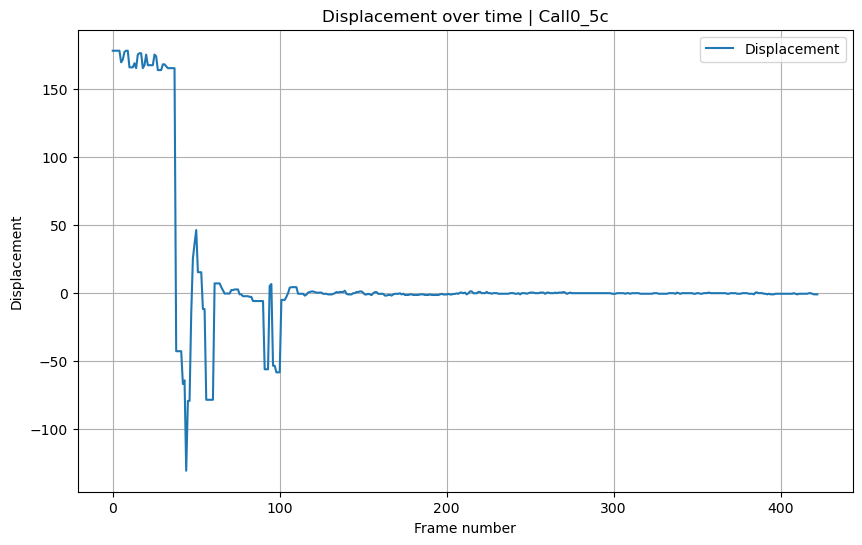

In [28]:
plot_displacement(displacements,"Call0_5c")

In [29]:
import numpy as np
from scipy import fftpack

def displacement_to_difference(displacement_array):
    displacement_array_copy = displacement_array.copy()
    dif_array = displacement_array_copy - np.roll(displacement_array_copy, -1)
    dif_array = dif_array[:-1]
    start_point = np.min(np.where(dif_array == np.max(dif_array)))
    return dif_array, start_point

#modify version of : https://github.com/MTNakata/AraVib/blob/master/AraVib_modules/AraVib_FFT.py#LL11C1-L12C1
#    --> fix hanning window according to the shape of the array 
def transform_hanning(displacement_array, start_point):
    hanning_length = len(displacement_array) - 2*start_point
    hanningWindow = np.concatenate([np.zeros(start_point),np.hanning(hanning_length), np.zeros(start_point)])
    displacement_array2 = displacement_array - np.mean(displacement_array[start_point:])
    displacement_array_hanning = displacement_array2 * hanningWindow
    return displacement_array_hanning


def displacement_to_major_freq(displacement_array,fps=240):
    time_step = 1/fps
    freq = fftpack.fftfreq(displacement_array.size,d=time_step)
    fft = fftpack.fft(displacement_array)
    pidxs = np.where(freq > 0)
    freqs = freq[pidxs]
    power = np.abs(fft)[pidxs]
    freqs2 = freqs[np.where(freqs > 2)]
    power2 = power[np.where(freqs > 2)]
    major_freq = freqs2[np.where(power2 >= max(power2))]
    return freqs, power, major_freq

In [30]:
#update hanning function to adapat it to any array 
def transform_hanning_adapt(displacement_array, start_point):
    # Get the length of the displacement array
    array_length = len(displacement_array)

    # Subtract the mean of the displacement array from the displacement array itself
    displacement_array2 = displacement_array - np.mean(displacement_array[start_point:])

    # If the displacement array is shorter than 240, return the mean-subtracted array
    if array_length < 240:
        return displacement_array2

    # Length of the Hanning window
    hanning_length = min(240, array_length)
    
    # The length of the zero-padding on either side of the hanning window
    pad_length = (array_length - hanning_length + 1) // 2  # added 1 to ensure correct padding

    # In case of odd total length, one padding needs to be longer
    if (pad_length * 2 + hanning_length) != array_length:
        pad_length_1 = pad_length
        pad_length_2 = pad_length + 1
    else:
        pad_length_1 = pad_length_2 = pad_length

    # Create the Hanning window with zero-padding
    hanningWindow = np.concatenate([np.zeros(pad_length_1), np.hanning(hanning_length), np.zeros(pad_length_2)])

    # Multiply the displacement array by the Hanning window
    displacement_array_hanning = displacement_array2 * hanningWindow
    return displacement_array_hanning



In [31]:
dif_array1, start_point1 = displacement_to_difference(displacements)
hanning_array1 = transform_hanning(displacements, start_point1)
freqs1, power1, major_freq1 = displacement_to_major_freq(hanning_array1)


In [32]:
print("ωd of {} = {:.4f} Hz".format(input_video_path,*major_freq1))

ωd of ../input_vids/Col0_5c_trim.mp4 = 2.8369 Hz


In [33]:
def freqs_power_graph(freqs, power, col="k"):
    fig = plt.figure(figsize=(13,10))
    ax = fig.add_subplot(111)
    ax.plot(freqs,power,color=col,marker=".",markersize=12,linewidth=3)
    
def plot_graph(data):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(data)

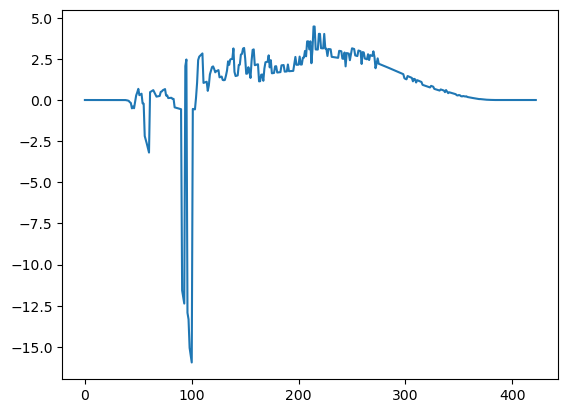

In [34]:
plot_graph(hanning_array1)


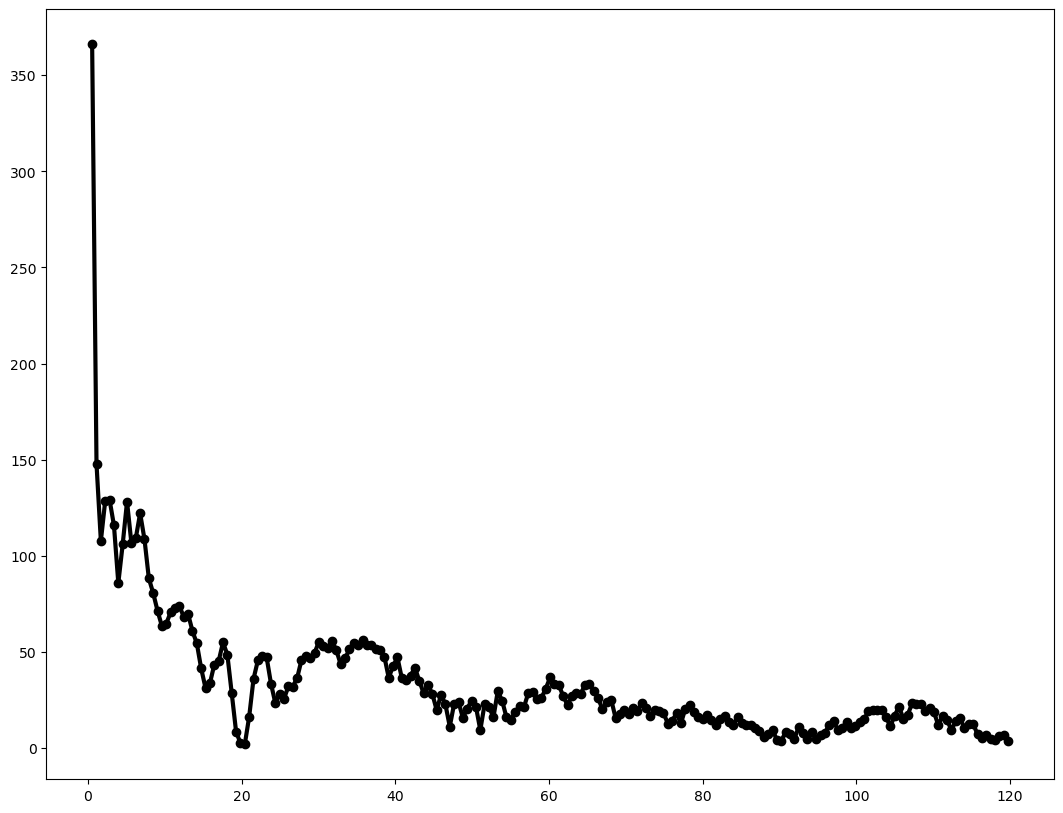

In [35]:
freqs_power_graph(freqs1, power1, col="k")

